### Testing notebook to execute a trained Faster-RCNN to detect swimmers' head on images or videos

If you plan to use this notebook with Google Colab you need first to mount your Google Drive by executing the first cell.

In [1]:

import os

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/') 

Mounted at /content/gdrive


Then we import the different modules.

transforms is imported from the .py files you should have in your working directory. It can be found here : https://github.com/pytorch/vision/tree/master/references/detection or in the current github repo.

In [23]:
import numpy as np

import torch
import torchvision
from PIL import Image, ImageDraw
import pandas as pd

from google.colab.patches import cv2_imshow #cv2.imshow doesnt work with Google Colab

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import transforms as T  

import cv2



Then we give the path towards the model (you need to modify it and give your path).

In [20]:
to_load_path = './model.pt' #Path towards the dictionnary which contains the weights of a trained Faster-RCNN ; #TO FILL

The following function is needed to instantiate the model. Just execute the cell.

In [16]:
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

   # create an anchor_generator for the FPN which by default has 5 outputs
   anchor_generator = AnchorGenerator(sizes=((10,), (20,), (30,), (40,), (50,)), aspect_ratios=tuple([(0.5, 1.0, 2.0) for _ in range(5)]))
        
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
    
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

The first cell allows you to test the model on any image zoomed on swimmers.

The secund cell allows you to test the model on a (zoomed) video. The path to the video must be specified. Without GPU acceleration, the calculations are long (about 4 seconds per frame of video of size 256x256). The path to the video must be specified.

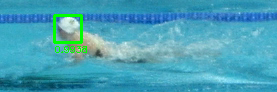

(array([[54.648006, 15.387943, 81.18403 , 42.985004]], dtype=float32),
 array([0.99375004], dtype=float32))

In [27]:
def analyse_image(image_path, thresh, model_path, colab=False) :
  """
  Parameters :
  image_path : path towards the image to analyse
  thresh : only detections with score above threshold are kept
  model_path : path towards the dictionnary which contains the weights of a trained Faster-RCNN
  colab : True if executing the notebook online (google Colab), False if executed locally.

  The function shows the image with rectangles drawn on the detections
  The function also returns a couple of array (boxes, scores) where
  boxes is an array of boxes [xmin,ymin,xmax,ymax] and scores is an array 
  which contains the corresponding prediction score
  """
  
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

  loaded_model = get_model(num_classes = 2)
  loaded_model.load_state_dict(torch.load(to_load_path, map_location=device))
  loaded_model.to(device)

  img_cv = cv2.imread(image_path)
  img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
  img= T.ToTensor()(img)[0].to(device)
 
  #put the model in evaluation mode
  loaded_model.eval()
  with torch.no_grad():
      prediction = loaded_model([img])
  
  for element in range(len(prediction[0]["boxes"])):
      boxes = prediction[0]["boxes"][element].cpu().numpy()
      score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                      decimals= 4)
      
      if score >= thresh:
        top_left = (int(boxes[0]), int(boxes[1]))
        bottom_right = (int(boxes[2]), int(boxes[3]))
        img_cv = cv2.rectangle(img_cv, top_left, bottom_right, (0,255,0),2) #draw a rectangle
        img_cv = cv2.putText(img_cv, str(score), (top_left[0], bottom_right[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1) #draw score

  if colab : #cv2.imshow doesnt work with Google Colab
    cv2_imshow(img_cv)
  else : 
    cv2.imshow(img_cv)

  return prediction[0]["boxes"].numpy(), prediction[0]["scores"].numpy()

image_path = '' #TO FILL
analyse_image(image_path,0.8, to_load_path)

In [1]:
# test sur une video

def analyse_video(video_path, out_path, thresh, model_path) :
  """
  Parameters :
  video_path : path towards the video to analyse
  out_path : path towards the video with rectangles on detections
  thresh : only detections with score above threshold are kept
  model_path : path towards the dictionnary which contains the weights of a trained Faster-RCNN

  The function writes a video at the requested location with each frame showing the
  bounding boxes detected by the Faster-RCNN with the requested threshold
  
  It returns a "box_head" list such that for each frame i, box_head[i] is a 
  list of lists of the form [frame, top_left, bottom_right] for each bounding box 
  on frame i  where frame is the number of the frame, top_left and botom_right are 
  the top left and bottom right point of the bouding box of the detection
  """

  # use GPU if CUDA is available otherwise use CPU
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

  loaded_model = get_model(num_classes = 2)
  loaded_model.load_state_dict(torch.load(to_load_path, map_location=device))
  loaded_model.to(device)

  box_head = []

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float 
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # float
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(out_path, fourcc, fps, (int(width),  int(height)))
  length = cap.get(cv2.CAP_PROP_FRAME_COUNT)

  #put the model in evaluation mode
  loaded_model.eval()
  with torch.no_grad():

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()
        num_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        print(str(num_frame)+' on '+str(length))

        if ret :
          img = frame
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB 
          im_tensor = T.ToTensor()(img)[0].to(device) #tensor 

        
          detection = loaded_model([im_tensor])

          
          N = len(detection[0]['boxes']) #Number of detections
          boxes = []
          for n in range(N) : 
            xmin, ymin,xmax, ymax = detection[0]['boxes'][n]
            score = detection[0]['scores'][n].item()

            if score>= thresh : 
              top_left = (int(xmin.item()), int(ymin.item()))
              bottom_right = (int(xmax.item()), int(ymax.item()))
              frame = cv2.rectangle(frame, top_left,bottom_right , (0,255,0), 2)
              boxes.append([num_frame, top_left, bottom_right])
              

          box_head.append(boxes)

              
          out.write(frame)

        else :
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return box_head

video_path = '' #TO FILL
out_path = '' #TO FILL

box_head = analyse_video(video_path, out_path , 0.8, to_load_path)

NameError: ignored